In [26]:
import os, scipy, sklearn, spacy, glob
import requests as req
import seaborn as sns
import hypertools as hyp
import pandas as pd
import numpy as np
from helpers import *
import html2text
import markdown
from bs4 import BeautifulSoup
from scipy.spatial.distance import cdist, pdist, squareform
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt

from nltk.corpus import stopwords as sw

%matplotlib notebook

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
fileid = '1hCCn31z4HM4IzQi59DP-vvUpYKhlvo2S'
datadir = '../data'
fname = os.path.join(datadir, 'data.csv')

if not os.path.exists(datadir):
    os.makedirs(datadir)
    
if not os.path.exists(fname):
    print('Fetching file from the interwebz!')
    dl(fileid, fname)
else:
    print('Data found!')

Data found!


In [3]:
data = pd.read_csv(fname)

In [4]:
data.head()

,id,title,url,writers,genres,script
0,1,10 Things I Hate About You,http://www.imsdb.com/scripts/10-Things-I-Hate-...,Karen McCullah Lutz;Kirsten Smith;William Shak...,Comedy;Romance,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...
1,2,12,http://www.imsdb.com/scripts/12.html,Lawrence Bridges,Comedy,\n\n \n 12 - Script\n
2,3,12 and Holding,http://www.imsdb.com/scripts/12-and-Holding.html,Anthony Cipriano,Drama,\n \n \n ...
3,4,12 Monkeys,http://www.imsdb.com/scripts/12-Monkeys.html,David Peoples;Janet Peoples,Drama;Sci-Fi;Thriller,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...
4,5,12 Years a Slave,http://www.imsdb.com/scripts/12-Years-a-Slave....,John Ridley,Drama,\r\n\r\n\r\n 12 YE...


## Clean scripts

In [5]:
a = [data['genres'].values[i].split(';') for i in range(len(data))]
a
genres = []
for i in a:
    for j in i:
        if len(j) > 1:
            for k in j.split('.'):
                genres.append(k.strip())
genres = np.unique(np.array(genres))
#genres = pd.DataFrame({'genre':genres}).drop_duplicates().sort_values(by='genre').reset_index(drop=True)
genres

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short',
       'Sport', 'Thriller', 'War', 'Western'], dtype='<U9')

In [6]:
for g in genres:
    data[g] = data['genres'].apply(lambda x: g in x)

In [12]:
data.dropna(inplace=True)

In [13]:
data['wiped_scripts'] = data['script'].apply(lambda x: cleanup_text(wipe_formatting(x)))

In [14]:
data.head()

,id,title,url,writers,genres,script,Action,Adventure,Animation,Biography,...,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,wiped_scripts
0,1,10 Things I Hate About You,http://www.imsdb.com/scripts/10-Things-I-Hate-...,Karen McCullah Lutz;Kirsten Smith;William Shak...,Comedy;Romance,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...,False,False,False,False,...,False,False,True,False,False,False,False,False,False,ten things i hate about you by karen mccullah ...
1,2,12,http://www.imsdb.com/scripts/12.html,Lawrence Bridges,Comedy,\n\n \n 12 - Script\n,False,False,False,False,...,False,False,False,False,False,False,False,False,False,twelve script
2,3,12 and Holding,http://www.imsdb.com/scripts/12-and-Holding.html,Anthony Cipriano,Drama,\n \n \n ...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,twelve and holding written by anthony s cipria...
3,4,12 Monkeys,http://www.imsdb.com/scripts/12-Monkeys.html,David Peoples;Janet Peoples,Drama;Sci-Fi;Thriller,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...,False,False,False,False,...,False,False,False,True,False,False,True,False,False,twelve monkeys twelve monkeys an original scre...
4,5,12 Years a Slave,http://www.imsdb.com/scripts/12-Years-a-Slave....,John Ridley,Drama,\r\n\r\n\r\n 12 YE...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,twelve years a slave written by john ridley ca...


In [16]:
data.to_csv('../data/data_wiped_scripts.csv')

In [522]:
# # genres = ['Sci-Fi','Comedy','Drama','Adventure']
# titles_by_genre = {}
# for genre in genres:
#     genre_titles = []
#     for ri,row in data.iterrows():
#         if genre in row['genres']:
#             genre_titles.append(row['title'])
#     titles_by_genre[genre] = genre_titles

In [523]:
# n_per_genre = 20
# titles = [titles_by_genre['Sci-Fi'][0:n_per_genre],
#           titles_by_genre['Comedy'][0:n_per_genre],
#           titles_by_genre['Comedy'][0:n_per_genre]]
# movie_ids = []
# for title in titles:
#     print(title)
#     [movie_ids.append(a) for a in list(data.query('title == @title').id.values)]
# print(movie_ids)

## Plot movies in topic space

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [20]:
import joblib

In [21]:
cv = joblib.load('../data/fit_cv.joblib')
lda = joblib.load('../data/fit_lda_t100.joblib')

In [159]:
lang_model_wiki = hyp.load('wiki_model')

In [162]:
def wiki_model_transform(text):
    return lang_model_wiki.transform([text])

In [163]:
topic_vectors = data['wiped_scripts'].apply(lambda x: wiki_model_transform(x))
topic_vectors = np.vstack(topic_vectors)

In [24]:
# topic_vectors = data['wiped_scripts'].apply(lambda x: lda.transform(cv.transform([x])))
# topic_vectors = np.vstack(topic_vectors)

<IPython.core.display.Javascript object>


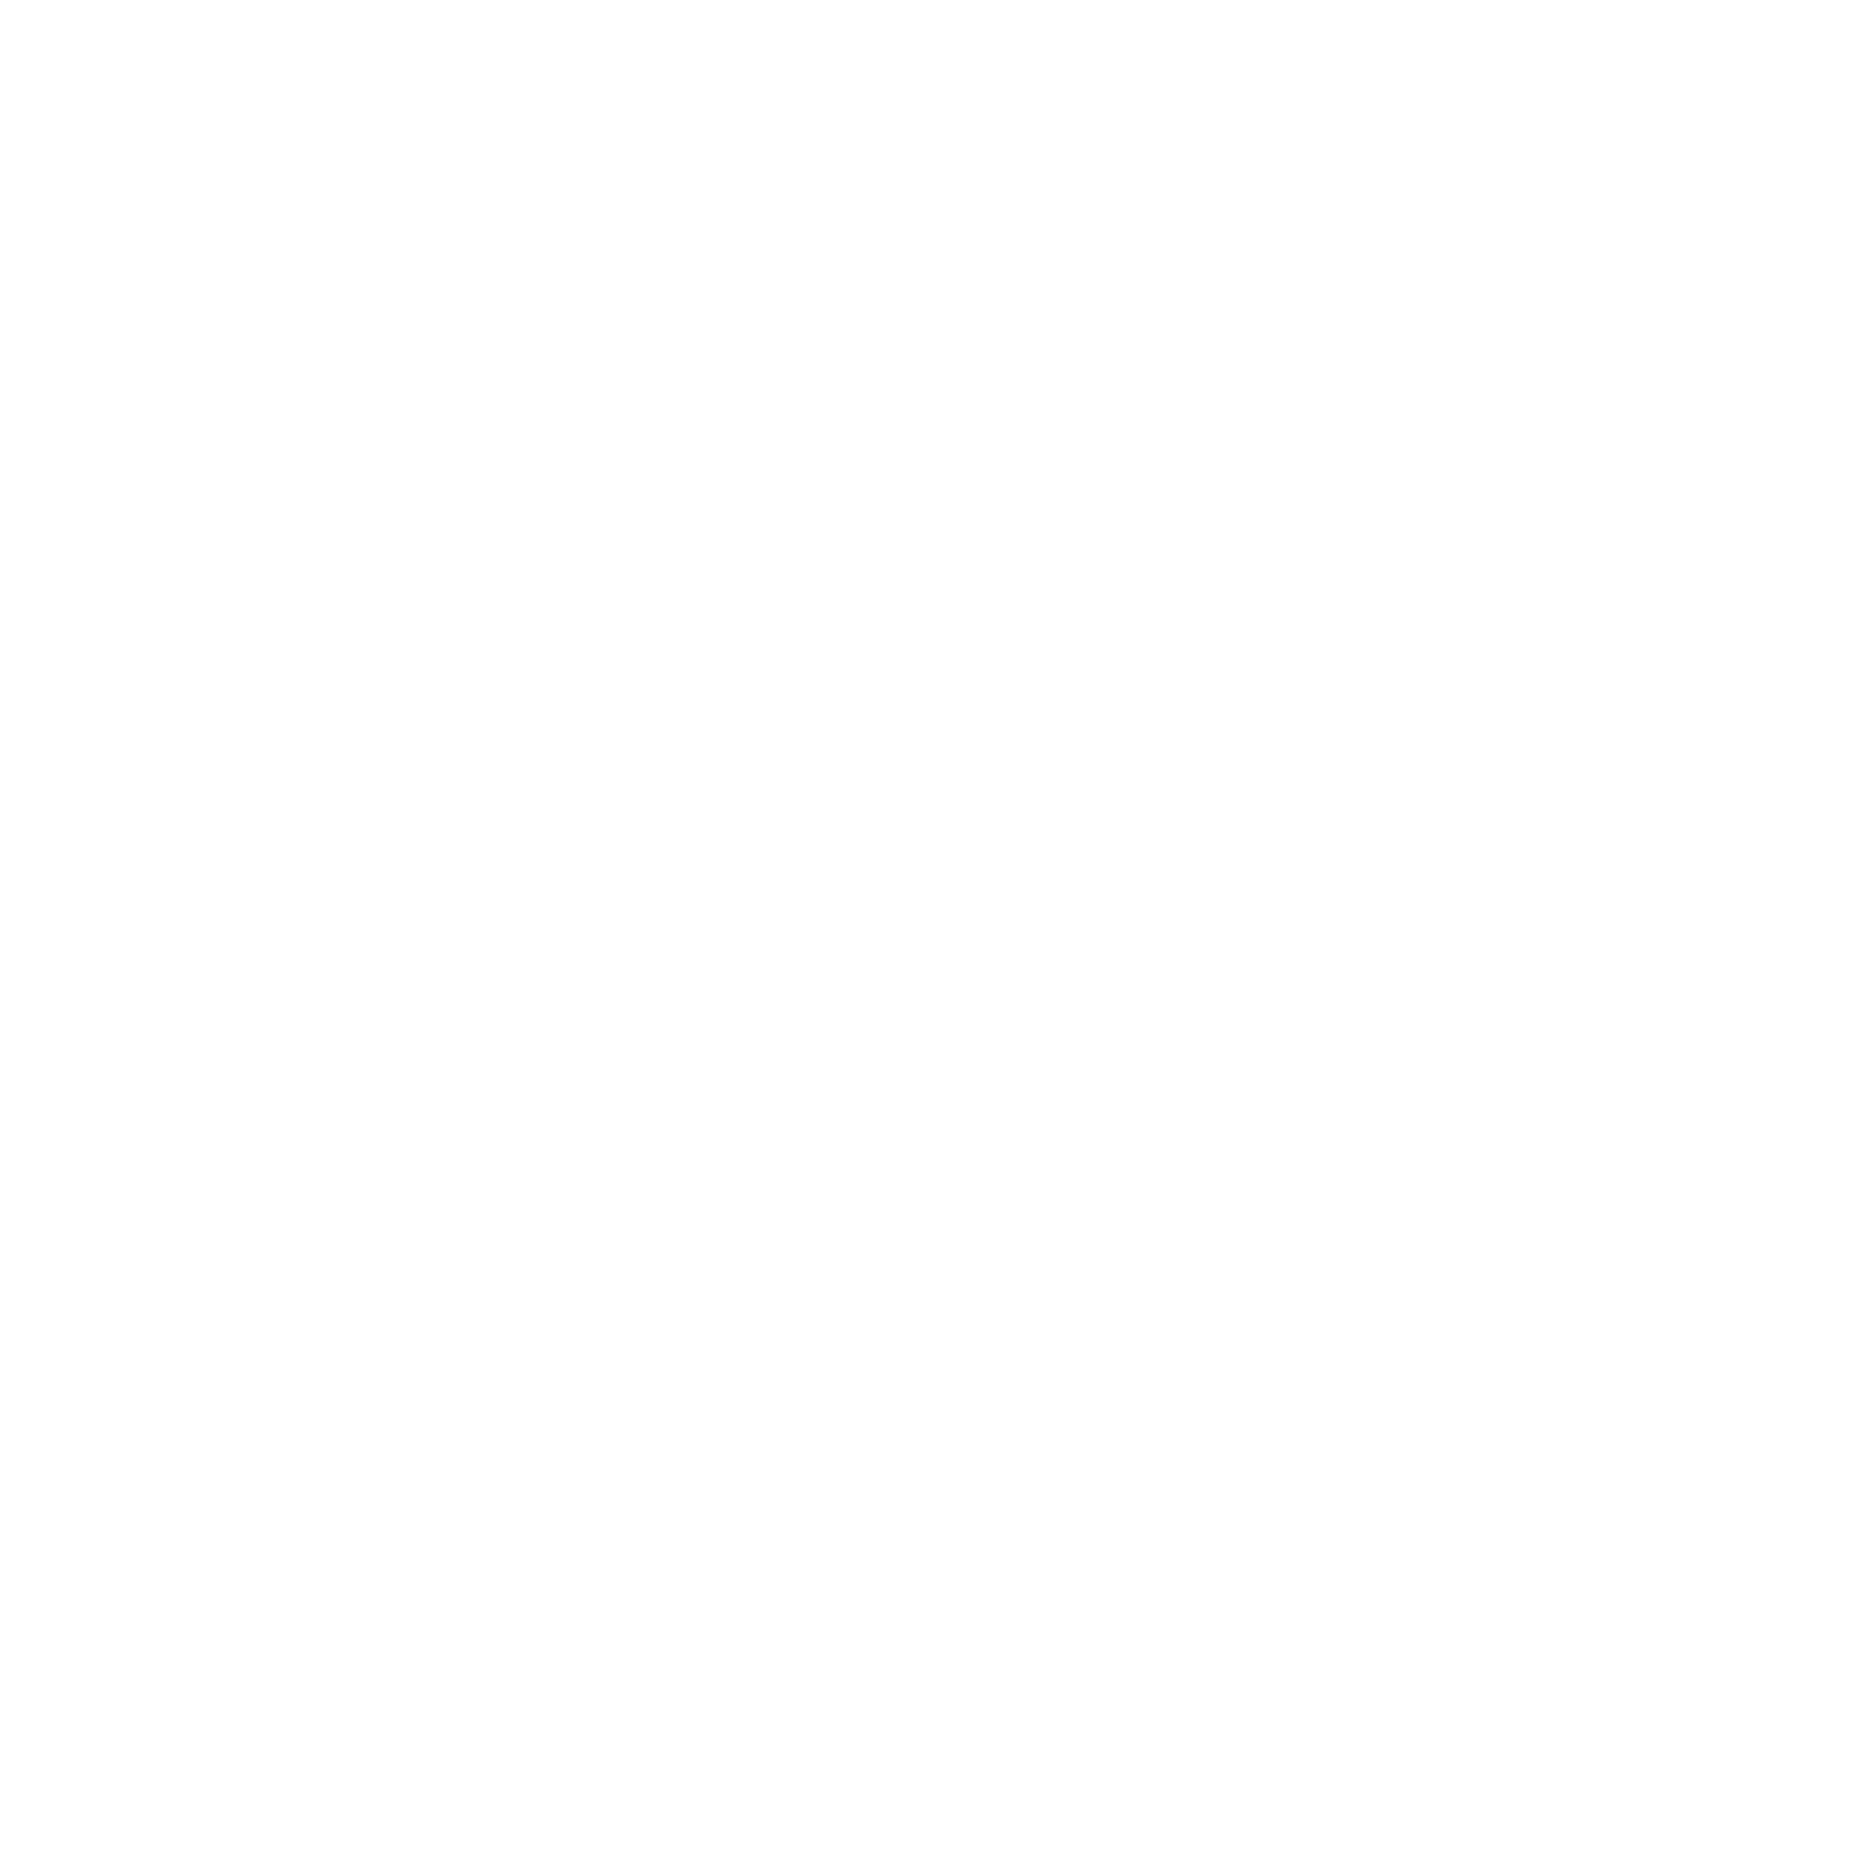

<IPython.core.display.Javascript object>


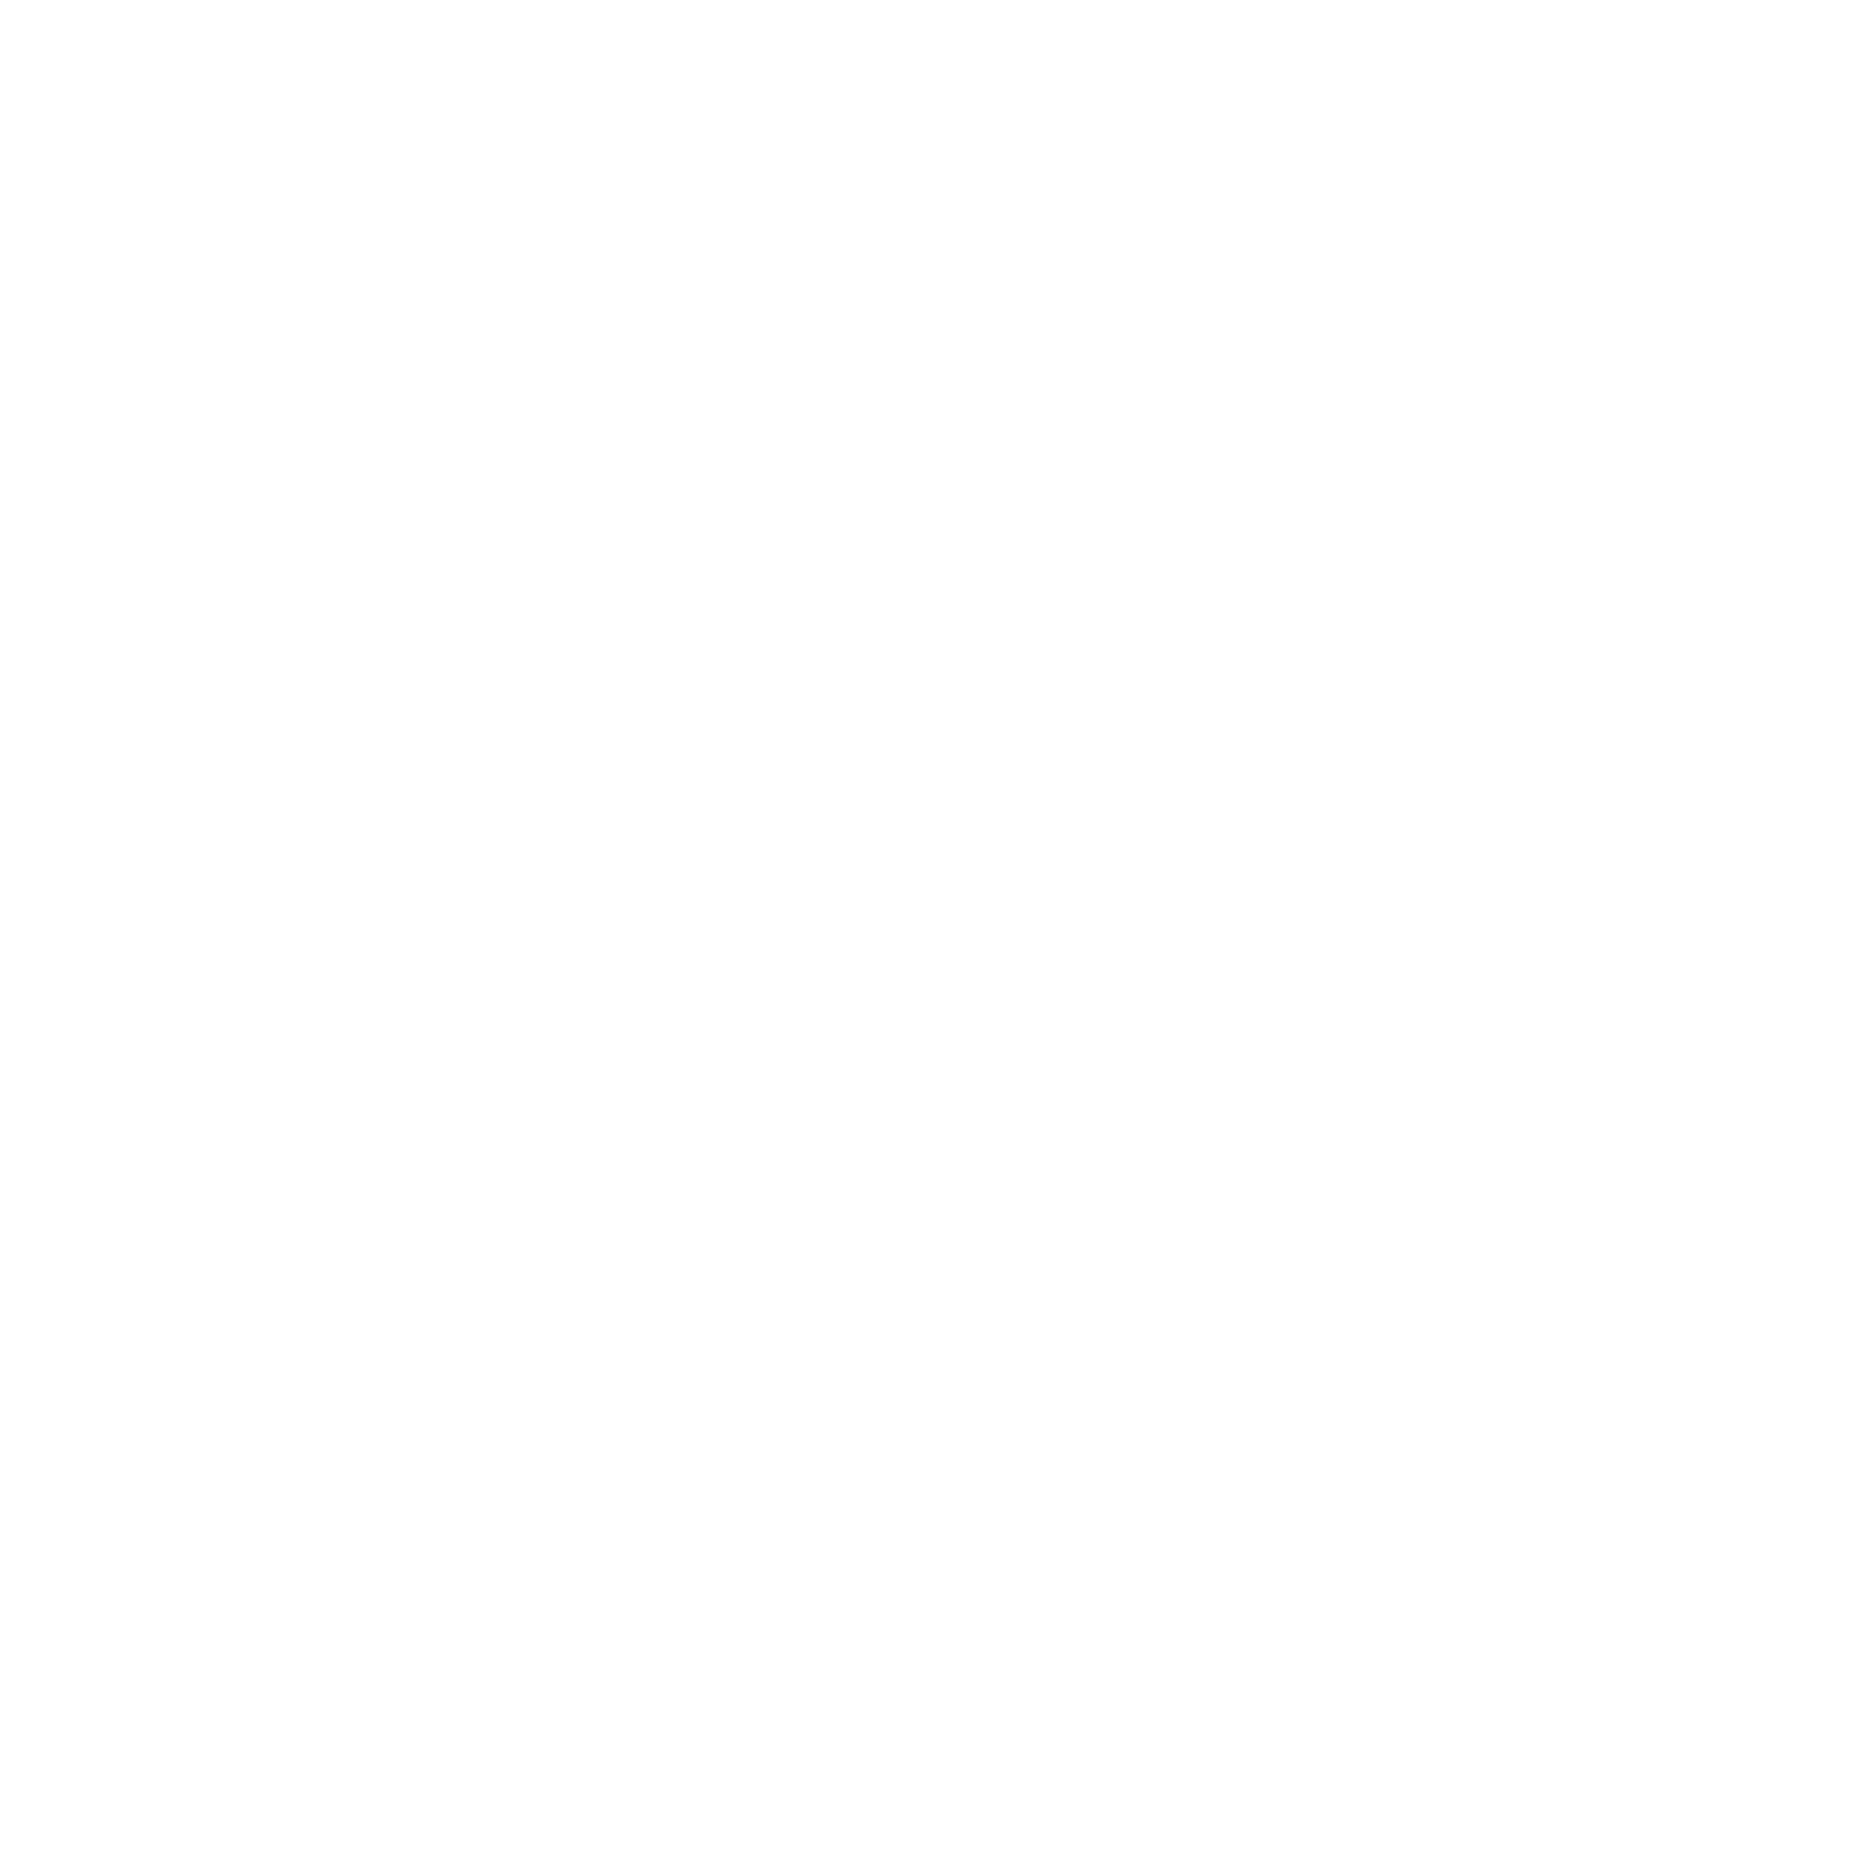

In [164]:
%matplotlib notebook
fig, ax = plt.subplots(4,4,figsize=[12,12])
ax = ax.flatten()
for ai, ax_current in enumerate(ax):
    genre_choice = genres[ai]
    hyp.plot(topic_vectors, '.', ndims = 2, hue = data[genre_choice], palette='tab10',
         legend=data[genre_choice].unique().tolist(), title = genre_choice, 
          ax = ax_current)
plt.savefig('/mnt/movie_space.pdf',bbox_inches='tight')

In [165]:
data_sorted = data.sort_values(by = list(genres), ascending=False)
topic_vectors_sorted = data_sorted['wiped_scripts'].apply(lambda x: wiki_model_transform(x))
topic_vectors_sorted = np.vstack(topic_vectors_sorted)

In [58]:
# data_sorted = data.sort_values(by = list(genres), ascending=False)
# topic_vectors_sorted = data_sorted['wiped_scripts'].apply(lambda x: lda.transform(cv.transform([x])))
# topic_vectors_sorted = np.vstack(topic_vectors_sorted)

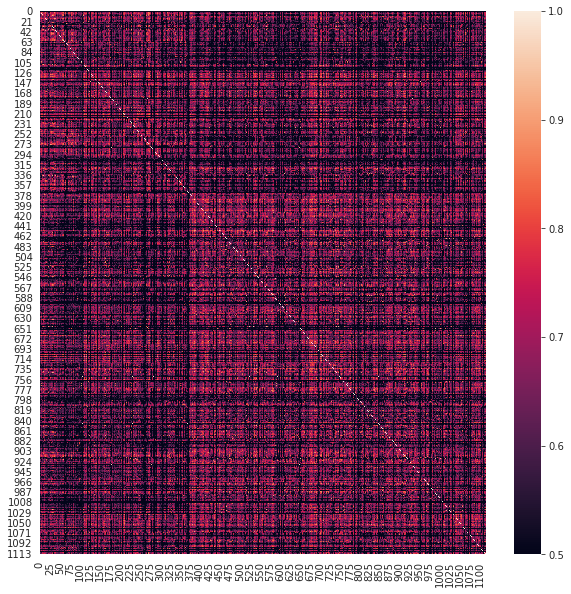

In [170]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=[10,10])
# sns.heatmap(sklearn.metrics.pairwise.cosine_similarity(topic_vectors_sorted),
#            ax = ax)
sns.heatmap(sklearn.metrics.pairwise.cosine_similarity(topic_vectors_sorted),
           ax = ax, vmin = 0.5)
# plt.show()

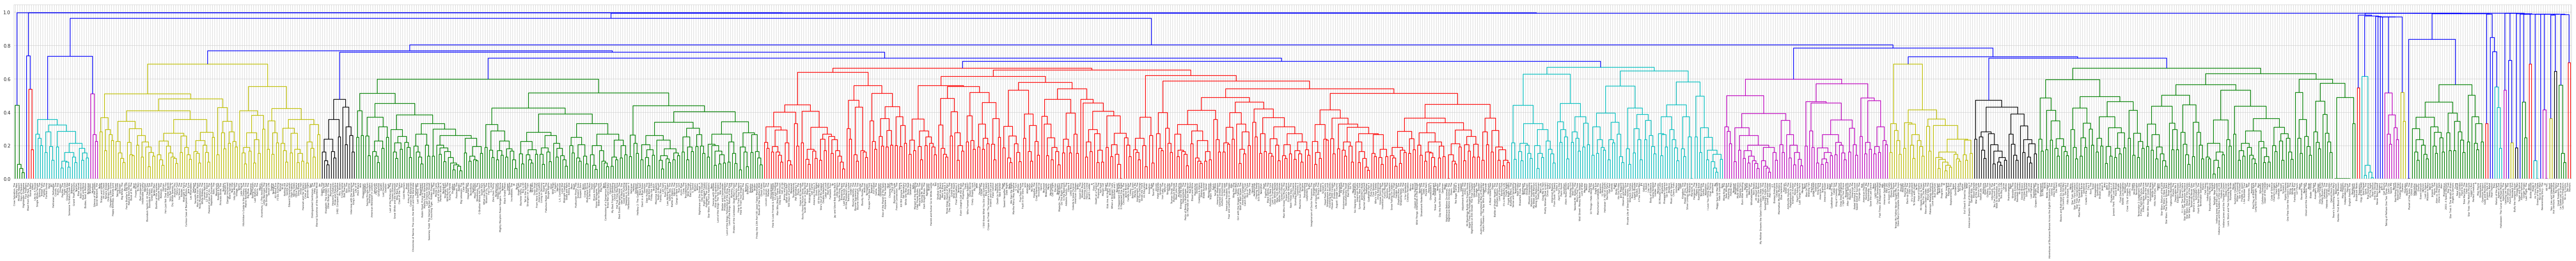

In [171]:
from scipy.cluster.hierarchy import dendrogram, linkage

movie_indices = np.arange(0,len(data),1)
linked = linkage(topic_vectors[movie_indices], method='complete',metric='cosine')

# labelList = range(1, 11)

plt.figure(figsize=(100, 7))
dendrogram(linked,
            labels=data.reset_index(drop=True).loc[movie_indices,'title'].values,
          )
plt.savefig('/mnt/%i_dendrogram_wiki.pdf'%len(movie_indices),bbox_inches='tight')

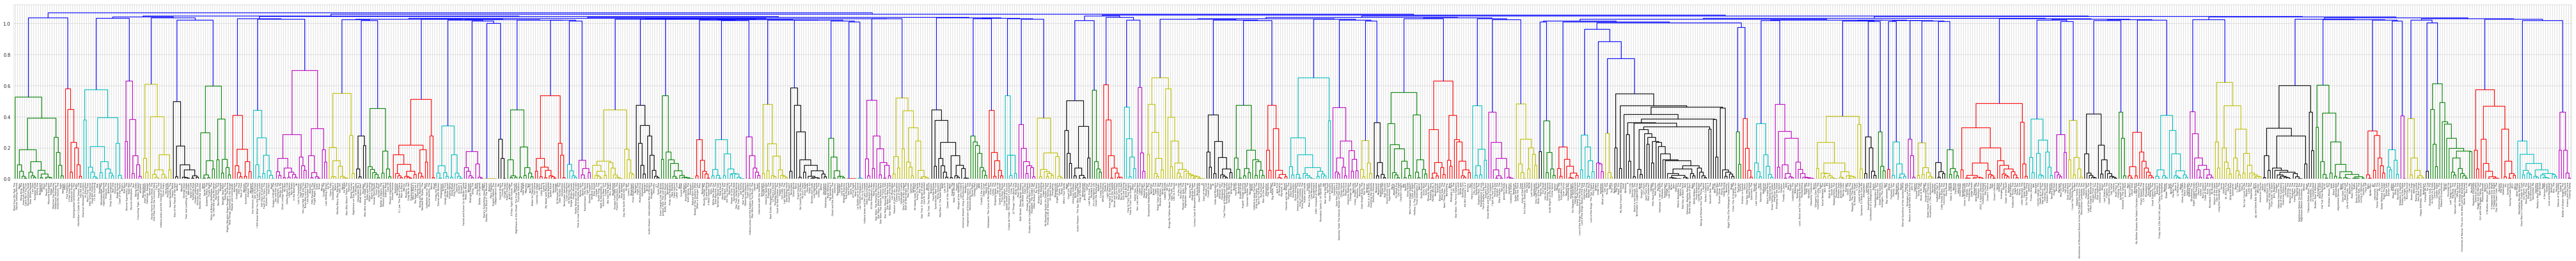

In [119]:
# from scipy.cluster.hierarchy import dendrogram, linkage

# movie_indices = np.arange(0,len(data),1)
# linked = linkage(topic_vectors[movie_indices], method='complete',metric='correlation')

# # labelList = range(1, 11)

# plt.figure(figsize=(100, 7))
# dendrogram(linked,
#             labels=data.reset_index(drop=True).loc[movie_indices,'title'].values,
#           )
# plt.savefig('/mnt/%i_dendrogram.pdf'%len(movie_indices),bbox_inches='tight')

## Compute similarity between movie script and review

In [125]:
# Load data with movie review IDs

In [126]:
data_with_reviews = pd.read_csv('../data/data_with_imdb_info.csv',index_col=0,
                               dtype={'imdb_id': str})

In [127]:
data_with_reviews = data_with_reviews.query('has_review == True')
data_with_reviews.head()

,id,title,url,writers,genres,script,imdb_id,has_review
3,4,12 Monkeys,http://www.imsdb.com/scripts/12-Monkeys.html,David Peoples;Janet Peoples,Drama;Sci-Fi;Thriller,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...,0114746,True
10,11,2001: A Space Odyssey,http://www.imsdb.com/scripts/2001-A-Space-Odys...,Stanley Kubrick;Arhur C. Clarke,Adventure;Sci-Fi,\n\n\t\t\t\t \n\t\t\t\t 2001: A SPACE OD...,0062622,True
19,20,8MM,http://www.imsdb.com/scripts/8MM.html,Andrew Kevin Walker,Mystery;Thriller,"\n\n\n ""8MM"", by Andrew Kevin Walker\n\n\n\n...",0134273,True
20,21,9,http://www.imsdb.com/scripts/9.html,Pamela Pettler;Shane Acker,Animation;Adventure;Drama;Fantasy;Sci-Fi,\n \n \n ...,0472033,True
52,53,Alone in the Dark,http://www.imsdb.com/scripts/Alone-in-the-Dark...,Elan Mastai;Michael Roesch,Action;Horror;Thriller,\n\n\n ALON...,0369226,True


In [154]:
movie_id = data_with_reviews['id'].values[30]
movie_dat = data_with_reviews.query('id == @movie_id')
title = movie_dat['title'].values[0]
script = wipe_formatting(movie_dat['script'].values[0])
imdb_id = movie_dat['imdb_id'].values[0]
print(title, imdb_id)
# movie_doc = nlp(script)
movie_vec = lda.transform(cv.transform([cleanup_text(script)]))

Cold Mountain 0159365


In [155]:
review_data = pd.read_csv('../data/review_data.csv',index_col=0,dtype={'imdb_id':str})
review_data = review_data.query('imdb_id == @imdb_id').copy().reset_index(drop=True)
review_data.head()

,url,imdb_id,set,sentiment,review_id
0,http://www.imdb.com/title/tt0159365/usercomments,0159365,test,neg,1753
1,http://www.imdb.com/title/tt0159365/usercomments,0159365,test,neg,1754
2,http://www.imdb.com/title/tt0159365/usercomments,0159365,test,neg,1755
3,http://www.imdb.com/title/tt0159365/usercomments,0159365,test,neg,1756
4,http://www.imdb.com/title/tt0159365/usercomments,0159365,test,neg,1757


In [156]:
review_data['sentiment'].unique()

array(['neg', 'pos'], dtype=object)

In [157]:
review_sim_results = pd.DataFrame()
for ri,review_dat in review_data.iterrows():
    review_set = review_dat['set']
    review_sentiment = review_dat['sentiment']
    filename = glob.glob('../../aclImdb/%s/%s/%i_*.txt'%(
        review_set,review_sentiment,review_dat['review_id']))[0]
    review_vec = lda.transform(cv.transform([cleanup_text(wipe_formatting(
        open(filename, 'r+', encoding="utf-8").read()))]))
#     review_doc = nlp(u'%s'%wipe_formatting(open(filename, 'r+', encoding="utf-8").read()))
    review_sim = sklearn.metrics.pairwise.cosine_similarity(movie_vec,review_vec)[0][0]
    review_sim_results = review_sim_results.append(pd.DataFrame(
        [[movie_id,title,imdb_id,ri,review_set, review_sentiment,review_sim]]))
review_sim_results = review_sim_results.reset_index(drop=True)
review_sim_results.columns = ['movie_id','title','imdb_id','review_id',
                              'review_set','review_sentiment','similarity_to_movie']

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0.0069327822901160616, 1)

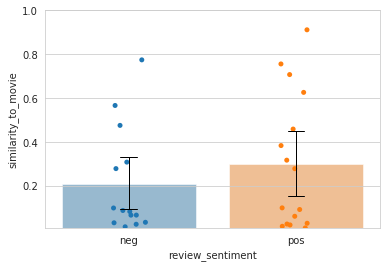

In [158]:
sns.barplot(data = review_sim_results, x = 'review_sentiment', y = 'similarity_to_movie',
           alpha = .5, errwidth = 0, zorder = 0)
sns.stripplot(data = review_sim_results, x = 'review_sentiment', y = 'similarity_to_movie',
             zorder = 1)
sns.barplot(data = review_sim_results, x = 'review_sentiment', y = 'similarity_to_movie',
           alpha = 0, errwidth = 1, capsize = .1, errcolor = 'k', zorder = 2)
plt.ylim([min(review_sim_results.similarity_to_movie),1])

## Use spacy to compute text similarity

In [120]:
nlp = spacy.load('en_core_web_lg')

In [123]:
import tqdm

In [124]:
script_vectors = pd.DataFrame()
movie_ids = np.arange(50,100)
dat_use = data.copy()  #loc[data['id'].isin(movie_ids)].
titles = dat_use['title']
docs = {}
for t in tqdm.tqdm(range(len(dat_use))):
    movie = dat_use.iloc[t,:]
# for mi,movie in dat_use.iterrows():
    doc = nlp(movie['wiped_scripts'])
    docs[movie['id']] = doc
    vec = pd.DataFrame(doc.vector).T
#     vec.set_index(movie['id'])
    script_vectors = script_vectors.append(vec)
script_vectors = script_vectors.reset_index(drop=True)

  0%|          | 4/1116 [00:09<51:25,  2.77s/it]Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

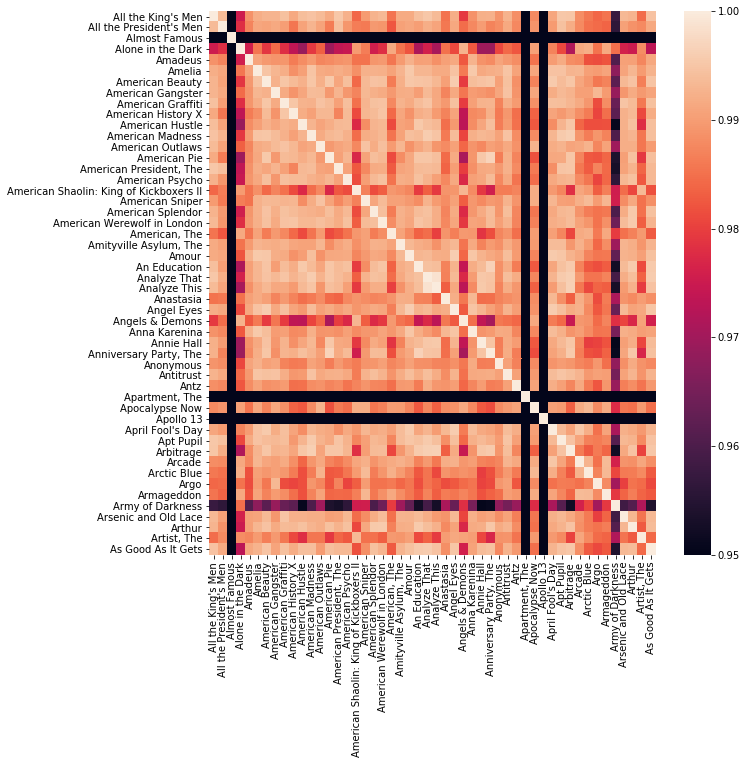

In [288]:
include = range(np.shape(script_vectors)[0])
titles_include = [titles.values[i] for i in include]
fig,ax = plt.subplots(1,1,figsize=[10,10])
sns.heatmap(sklearn.metrics.pairwise.cosine_similarity(
    script_vectors.iloc[include,:]),vmin = 0.95,
            xticklabels = titles_include, yticklabels = titles_include,
           ax=ax)